# Install and Import Necessary Packages and Libraries

In [118]:
import pandas as pd
import seaborn as sns
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import os
import random
import matplotlib.image as mpimg
from textwrap import wrap
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D,  Input, Dense, Reshape, Embedding, LSTM, Dropout, concatenate, add, LeakyReLU
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from wandb.integration.keras import WandbCallback
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [119]:
import warnings
warnings.filterwarnings('ignore')

In [120]:
enable_wandb = True
use_gpu = True

In [121]:
gpu_available = torch.cuda.is_available()
gpu_available

True

In [122]:
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

# Data Preparation

## Unzip Folder

In [6]:
# f = zipfile.ZipFile("/projectnb/ba890/students/yfliao/Flickr8kDataset.zip",'r')
# for file in f.namelist():
#     f.extract(file,"/projectnb/ba890/students/yfliao")
# f.close()

## Check Dataset

In [123]:
caption_file = '/projectnb/ba890/students/yfliao/Flickr8kDataset/captions.txt'
captions = pd.read_csv(caption_file)
pd.set_option('display.width', 1000)
captions.head()

image                                                                   caption
0  1000268201_693b08cb0e.jpg  A child in a pink dress is climbing up a set of stairs in an entry way .
1  1000268201_693b08cb0e.jpg                                     A girl going into a wooden building .
2  1000268201_693b08cb0e.jpg                          A little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg                      A little girl climbing the stairs to her playhouse .
4  1000268201_693b08cb0e.jpg                 A little girl in a pink dress going into a wooden cabin .

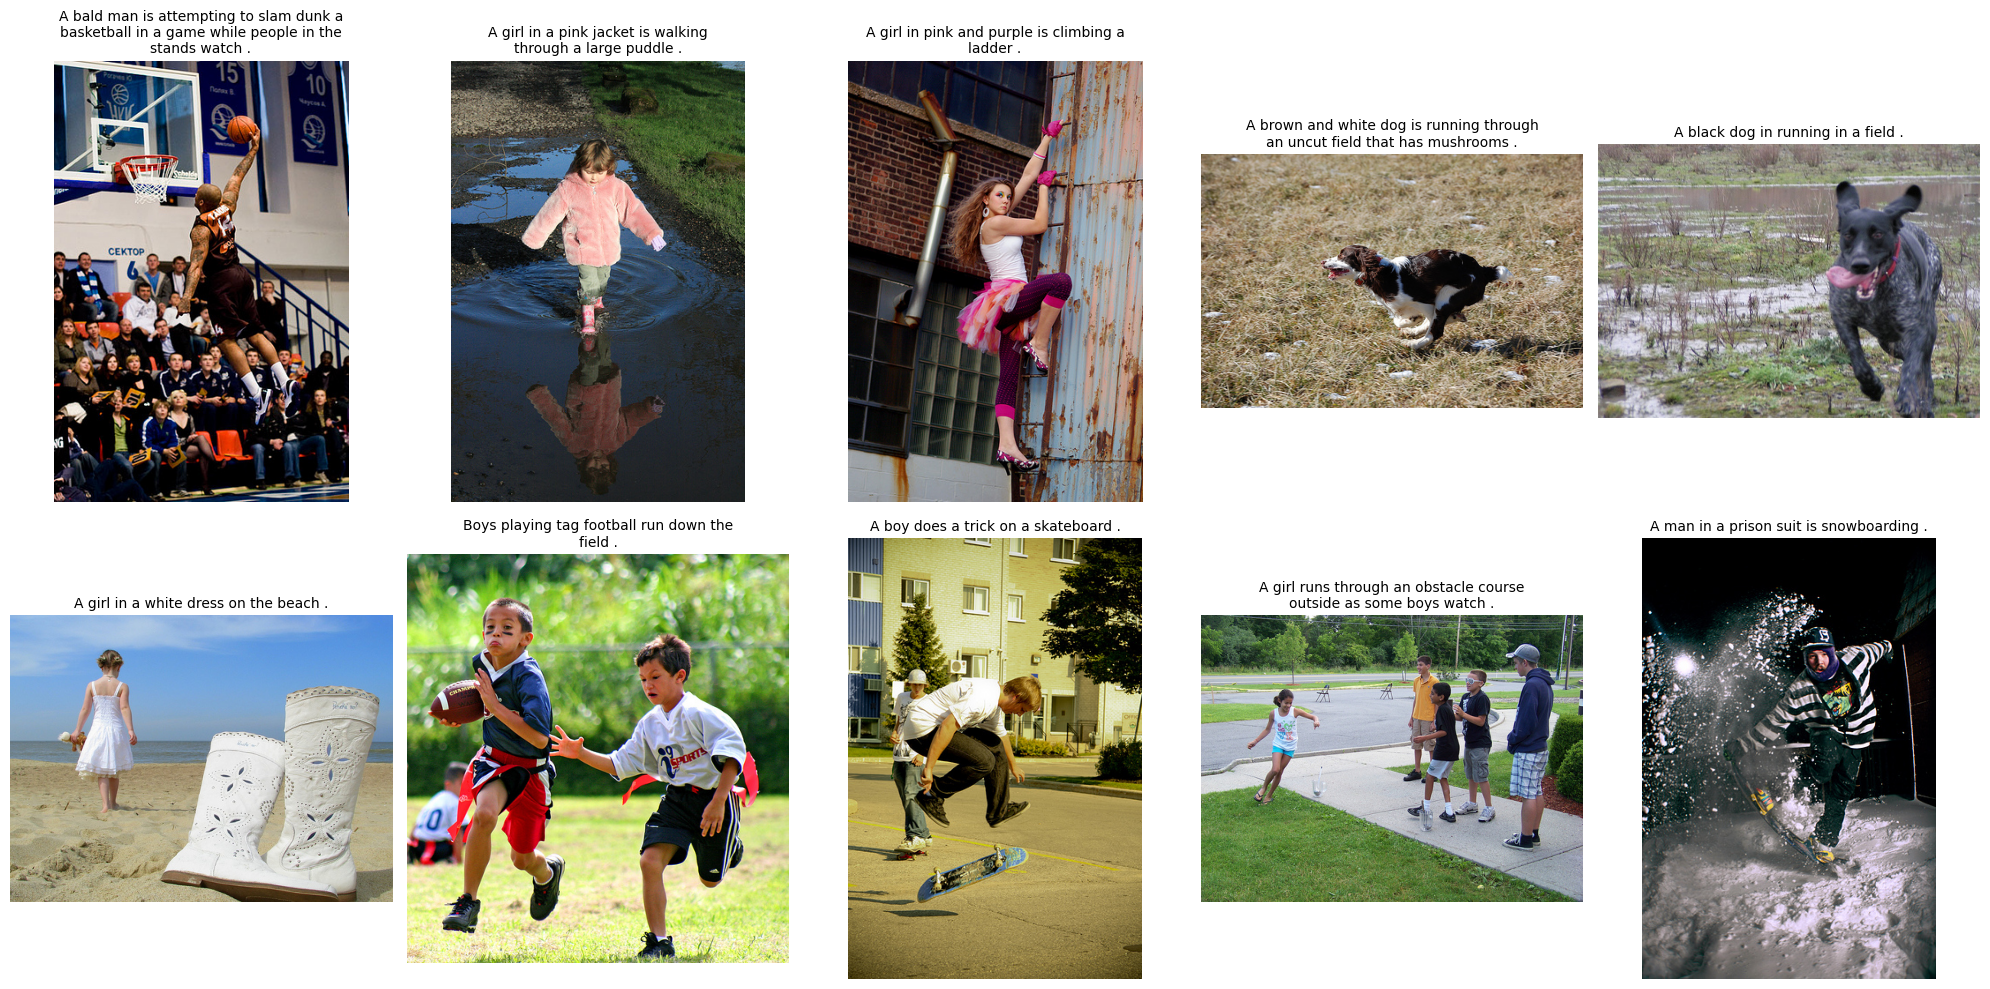

In [124]:
image_dir = '/projectnb/ba890/students/yfliao/Flickr8kDataset/Images'

# All image files
all_images = [img for img in os.listdir(image_dir) if img.endswith('.jpg')]

# Randomly pick 10 images
selected_images = random.sample(all_images, 10)

# Plot the images with captions
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, image_file in enumerate(selected_images):
    # Corresponding caption
    image_name = image_file
    caption = captions[captions['image'] == image_name]['caption'].values[0]
    wrapped_caption = '\n'.join(wrap(caption, 40))  # Wrap text after 40 characters

    # Load and display the image
    image_path = os.path.join(image_dir, image_file)
    img = mpimg.imread(image_path)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(wrapped_caption, fontsize=10)  # Set caption as title
    ax.axis('off')

plt.tight_layout()
plt.show()

## Caption Tokenization

In [125]:
captions['cln_caption'] = captions['caption']
captions['cln_caption'] = captions['cln_caption'].str.lower() # To lower case
captions['cln_caption'] = captions['cln_caption'].str.strip() # Remove trailing spaces
captions['cln_caption'] = captions['cln_caption'].str.replace('[^\w\s\d+\s+]','') # Remove punctuation, numbers, and spaces
captions['cln_caption'] = captions['cln_caption'].apply(lambda x: ' '.join(word for word in x.split() if len(word) > 1)) # Remove words with only one character
captions['cln_caption'] = 'startseq ' + captions['cln_caption'] + ' endseq'
pd.set_option('display.max_colwidth', None)
captions.head()

image                                                                   caption                                                                       cln_caption
0  1000268201_693b08cb0e.jpg  A child in a pink dress is climbing up a set of stairs in an entry way .  startseq child in pink dress is climbing up set of stairs in an entry way endseq
1  1000268201_693b08cb0e.jpg                                     A girl going into a wooden building .                                   startseq girl going into wooden building endseq
2  1000268201_693b08cb0e.jpg                          A little girl climbing into a wooden playhouse .                        startseq little girl climbing into wooden playhouse endseq
3  1000268201_693b08cb0e.jpg                      A little girl climbing the stairs to her playhouse .                  startseq little girl climbing the stairs to her playhouse endseq
4  1000268201_693b08cb0e.jpg                 A little girl in a pink dress going into a wooden cabin .                 startseq little girl in pink dress going into wooden cabin endseq

In [126]:
# Word tokenize
nltk.download('punkt')
captions['tokenized'] = captions['cln_caption'].apply(word_tokenize)
print(captions['tokenized'][:5])

[nltk_data] Downloading package punkt to
[nltk_data]     /usr4/ba890/yfliao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    [startseq, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, endseq]
1                                              [startseq, girl, going, into, wooden, building, endseq]
2                                  [startseq, little, girl, climbing, into, wooden, playhouse, endseq]
3                          [startseq, little, girl, climbing, the, stairs, to, her, playhouse, endseq]
4                        [startseq, little, girl, in, pink, dress, going, into, wooden, cabin, endseq]
Name: tokenized, dtype: object


In [135]:
# Initialize tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions['tokenized'].apply(lambda x: ' '.join(x)))

# Max length --> the longest tokenized caption
config['max_length'] = max(len(tokens) for tokens in captions['tokenized'])

# Convert to sequences of integers
captions['sequences'] = tokenizer.texts_to_sequences(captions['tokenized'].apply(lambda x: ' '.join(x)))
print(captions['sequences'][:5])

0    [1, 42, 3, 89, 171, 6, 118, 50, 392, 11, 393, 3, 27, 5145, 669, 2]
1                                         [1, 18, 315, 63, 195, 116, 2]
2                                    [1, 39, 18, 118, 63, 195, 2428, 2]
3                             [1, 39, 18, 118, 4, 393, 19, 59, 2428, 2]
4                        [1, 39, 18, 3, 89, 171, 315, 63, 195, 2973, 2]
Name: sequences, dtype: object


In [136]:
# Train-test dataset
train, test = train_test_split(captions, test_size=0.2, random_state=42)

# Model

In [134]:
# Configuration

# # Exp 1
# config = {
#     "project_name": "Image Captioning",
#     "experiment_name": "DenseNet201+LSTM_08092221",
#     "pretrained": True,
#     "learning_rate": 0.001,
#     "batch_size": 64,
#     "epochs": 50,
#     "weight_decay": 0.0001,
#     "image_size": 224,
#     "vocab_size": len(tokenizer.word_index) + 1,  # +1 to account for the padding token
#     "max_length": max(len(caption.split()) for caption in captions['cln_caption']),
#     "model_name": "model.keras",
#     "image_path": "/projectnb/ba890/students/yfliao/Flickr8kDataset/Images",
# }


# # Exp 2 --> base on cln_caption
# config = {
#     "project_name": "Image Captioning",
#     "experiment_name": "ResNet50+LSTM_08092248",
#     "pretrained": True,
#     "learning_rate": 0.001,
#     "batch_size": 64,
#     "epochs": 50,
#     "weight_decay": 0.0001,
#     "image_size": 224,
#     "vocab_size": len(tokenizer.word_index) + 1,  # +1 to account for the padding token
#     "max_length": max(len(caption.split()) for caption in captions['cln_caption']),
#     "model_name": "resnet50_LSTM_model.keras",
#     "image_path": "/projectnb/ba890/students/yfliao/Flickr8kDataset/Images",
# }

# Exp 3 --> base on tokenized by nltk
# config = {
#     "project_name": "Image Captioning",
#     "experiment_name": "ResNet50+LSTM_08101236_tokenized_nltk",
#     "pretrained": True,
#     "learning_rate": 0.001,
#     "batch_size": 64,
#     "epochs": 50,
#     "weight_decay": 0.0001,
#     "image_size": 224,
#     "vocab_size": len(tokenizer.word_index) + 1,  # +1 to account for the padding token
#     "max_length": max(len(caption.split()) for caption in captions['cln_caption']),
#     "model_name": "resnet50_LSTM_model.keras",
#     "image_path": "/projectnb/ba890/students/yfliao/Flickr8kDataset/Images",
# }

# # Exp 4 --> add activation, optimizer
# config = {
#     "project_name": "Image Captioning",
#     "experiment_name": "ResNet50+LSTM_08101236_tokenized_nltk",
#     "pretrained": True,
#     "learning_rate": 0.001,
#     "batch_size": 64,
#     "epochs": 50,
#     "weight_decay": 0.0001,
#     "image_size": 224,
#     "vocab_size": len(tokenizer.word_index) + 1,  # +1 to account for the padding token
#     "max_length": max(len(caption.split()) for caption in captions['cln_caption']),
#     "model_name": "resnet50_LSTM_model.keras",
#     "image_path": "/projectnb/ba890/students/yfliao/Flickr8kDataset/Images",
#     "activation":'relu',
#     "optimizer":'adam'    
# }

# # Exp 5
# config = {
#     "project_name": "Image Captioning",
#     "experiment_name": "DenseNet201+LSTM_tokenized_nltk_08110428",
#     "pretrained": True,
#     "learning_rate": 0.001,
#     "batch_size": 64,
#     "epochs": 50,
#     "weight_decay": 0.0001,
#     "image_size": 224,
#     "vocab_size": len(tokenizer.word_index) + 1,  # +1 to account for the padding token
#     "max_length": max(len(caption.split()) for caption in captions['cln_caption']),
#     "model_name": "resnet50_LSTM_model.keras",
#     "image_path": "/projectnb/ba890/students/yfliao/Flickr8kDataset/Images",
#     "activation":'relu',
#     "optimizer":'adam'   
# }

# # Exp 6
# config = {
#     "project_name": "Image Captioning",
#     "experiment_name": "DenseNet201+LSTM_tokenized_nltk_08110835",
#     "pretrained": True,
#     "learning_rate": 0.001,
#     "batch_size": 64,
#     "epochs": 50,
#     "weight_decay": 0.0001,
#     "image_size": 224,
#     "vocab_size": len(tokenizer.word_index) + 1,  # +1 to account for the padding token
#     "max_length": max(len(caption.split()) for caption in captions['cln_caption']),
#     "model_name": "resnet50_LSTM_model.keras",
#     "image_path": "/projectnb/ba890/students/yfliao/Flickr8kDataset/Images",
#     "activation":'relu',
#     "optimizer":'adam'  
# }

# # Exp 7
# config = {
#     "project_name": "Image Captioning",
#     "experiment_name": "DenseNet201+LSTM_tokenized_nltk_08111853",
#     "pretrained": True,
#     "learning_rate": 0.001,
#     "batch_size": 64,
#     "epochs": 50,
#     "weight_decay": 0.0001,
#     "image_size": 224,
#     "vocab_size": len(tokenizer.word_index) + 1,  # +1 to account for the padding token
#     "max_length": max(len(caption.split()) for caption in captions['cln_caption']),
#     "model_name": "resnet50_LSTM_model_final.keras",
#     "image_path": "/projectnb/ba890/students/yfliao/Flickr8kDataset/Images",
#     "activation":'relu',
#     "optimizer":'adam'   
# }

# Refine
config = {
    "project_name": "Image Captioning",
    "experiment_name": "DenseNet201+LSTM_tokenized_nltk_08112233",
    "pretrained": True,
    "learning_rate": 0.001,
    "batch_size": 64,
    "epochs": 50,
    "weight_decay": 0.0001,
    "image_size": 224,
    "vocab_size": len(tokenizer.word_index) + 1,  # +1 to account for the padding token
    "max_length": max(len(caption.split()) for caption in captions['cln_caption']),
    "model_name": "resnet50_LSTM_model_refine_08112233.keras",
    "image_path": "/projectnb/ba890/students/yfliao/Flickr8kDataset/Images",
    "activation":'relu',
    "optimizer":'adam'
}

In [137]:
images = captions['image'].unique().tolist() # Unique image identifiers
nimages = len(images)  # Number of images

# Split train - validation data
split_index = round(0.85 * nimages)
train_images = images[:split_index]
val_images = images[split_index:]

# Filter captions
train = captions[captions['image'].isin(train_images)]
test = captions[captions['image'].isin(val_images)]

train.reset_index(inplace = True, drop = True)
test.reset_index(inplace = True, drop = True)

In [138]:
# Feature extraction

# DenseNet201
model = DenseNet201(weights = 'imagenet' if config['pretrained'] else None)
fe = Model(inputs = model.input, outputs = model.layers[-2].output)

"""""""""
# # ResNet50
# model = ResNet50(weights='imagenet', include_top=False)
# x = model.output
# x = GlobalAveragePooling2D()(x) 
# fe = Model(inputs=model.input, outputs=x)
"""""""""

# Extract features for each image
features = {}
for image in tqdm(train['image'].unique().tolist() + test['image'].unique().tolist()):
    img = load_img(os.path.join(config['image_path'], image), target_size = (config['image_size'], config['image_size']))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis = 0)
    feature = fe.predict(img, verbose = 0)
    features[image] = feature

100%|██████████| 8091/8091 [14:18<00:00,  9.42it/s]


In [148]:
class DataBatchGenerator(Sequence):
    
    # Initialization
    def __init__(self, dataframe, image_col, caption_col, batch_size, data_dir, tokenizer, vocab_size, max_seq_len, feature_dict, shuffle=True):
        self.dataframe = dataframe.copy()
        self.image_col = image_col
        self.caption_col = caption_col
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.feature_dict = feature_dict
        self.shuffle = shuffle
        self.data_len = len(self.dataframe)
        self.on_epoch_end()

    # Number of batches
    def __len__(self):
        return int(np.floor(self.data_len / self.batch_size))

    # Get Batch data
    def __getitem__(self, index):
        batch_indices = self.dataframe.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.loc[batch_indices]
        image_features, input_sequences, output_labels = self._get_batch_data(batch_data)
        return (image_features, input_sequences), output_labels

    # Shuffle data --> to prevent overfitting, ensure generalization and avoid bias in time series data
    def on_epoch_end(self):
        if self.shuffle:
            self.dataframe = self.dataframe.sample(frac = 1).reset_index(drop=True)

    # Generate Batch data
    def _get_batch_data(self, batch_data):
        image_features, input_sequences, output_labels = [], [], []
        for _, row in batch_data.iterrows():
            img_feature = self.feature_dict[row[self.image_col]][0]
            caption_seqs = self._create_caption_sequences(row[self.caption_col])
            for in_seq, out_seq in caption_seqs:
                image_features.append(img_feature)
                input_sequences.append(in_seq)
                output_labels.append(out_seq)
        return np.array(image_features), np.array(input_sequences), np.array(output_labels)

    # Create Caption sequences
    def _create_caption_sequences(self, caption):
        sequences = []
        tokenized_caption = self.tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(tokenized_caption)):
            in_seq = pad_sequences([tokenized_caption[:i]], maxlen = self.max_seq_len)[0]
            out_seq = to_categorical([tokenized_caption[i]], num_classes = self.vocab_size)[0]
            sequences.append((in_seq, out_seq))
        return sequences

In [149]:
# Model definition

input1 = Input(shape = (1920,)) # DenseNet201, input for image features
"""
#input1 = Input(shape = (2048,))  # ResNet50, input for image features
"""
input2 = Input(shape = (int(config['max_length']),)) # Input for tokenized caption sequences

#img_features = Dense(256, activation=config['activation_img_dense'])(input1)
img_features = Dense(256, activation = config['activation'])(input1)
img_features_reshaped = Reshape((1, 256), input_shape = (256,))(img_features)

sentence_features = Embedding(config['vocab_size'], 256, mask_zero = False)(input2) # Embedding layer to the input captions
merged = concatenate([img_features_reshaped, sentence_features], axis = 1) # Reshaped image features + sentece features

# LSTM layer
sentence_features = LSTM(256)(merged) 
x = Dropout(0.5)(sentence_features) # reduce overfitting
x = add([x, img_features]) # LSTM output to the original image features

#x = Dense(128, activation=config['activation_lstm_dense'])(x)
x = Dense(128, activation=config['activation'])(x)
x = Dropout(0.5)(x)

output = Dense(config['vocab_size'], activation = 'softmax')(x)

# Final model, inputs: image features + tokenized caption sequences, output
caption_model = Model(inputs = [input1, input2], outputs = output)

# Compile
caption_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

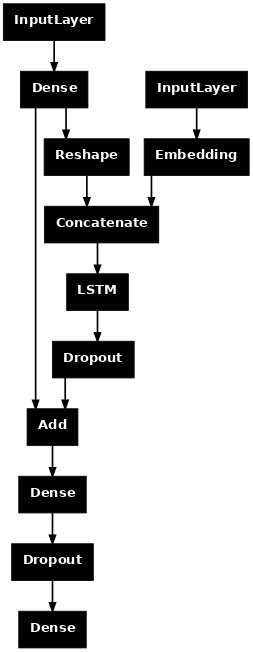

In [218]:
# Final model structure
plot_model(caption_model, dpi = 60)

In [150]:
caption_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    491,776 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 256)    │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 34, 256)   │  2,172,160 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 35, 256)   │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    525,312 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256)       │          0 │ dropout_4[0][0],  │
│                     │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8485)      │  1,094,565 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [151]:
# Train and validation generators
train_generator = DataBatchGenerator(dataframe=train, 
                                     image_col='image', 
                                     caption_col='tokenized', 
                                     batch_size=config['batch_size'], 
                                     data_dir=config['image_path'],
                                     tokenizer=tokenizer,
                                     vocab_size=config['vocab_size'], 
                                     max_seq_len=config['max_length'], 
                                     feature_dict=features)

validation_generator = DataBatchGenerator(dataframe=test,
                                          image_col='image',
                                          caption_col='tokenized', 
                                          batch_size=config['batch_size'], 
                                          data_dir=config['image_path'], 
                                          tokenizer=tokenizer, 
                                          vocab_size=config['vocab_size'], 
                                          max_seq_len=config['max_length'], 
                                          feature_dict=features)

# Checkpoint, Early-stopping, and Learning Rate Reduction

In [152]:
# Training callbacks
# Checkpoint: Save the model with the lowest validation loss
checkpoint = ModelCheckpoint(config['model_name'], 
                             monitor="val_loss", 
                             mode="min", 
                             save_best_only=True, 
                             verbose=1)

# Earlystopping: Stop training early if validation loss doesn't improve
earlystopping = EarlyStopping(monitor='val_loss', 
                              min_delta=0, 
                              patience=5, 
                              verbose=1, 
                              restore_best_weights=True)

# ReduceLROnPlateau: Reduce learning rate when validation loss plateaus
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

# Training

In [144]:
# Initialize wandb
wandb.init(
    project=config["project_name"],
    name=config["experiment_name"],
    config=config
)

In [145]:
# Logging to Wandb
class WandbLoggerCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        wandb.log({
            'epoch': epoch,
            'loss': logs.get('loss'),
            'val_loss': logs.get('val_loss'),
            'accuracy': logs.get('accuracy'),
            'val_accuracy': logs.get('val_accuracy')
        })

# Instantiate
wandb_callback = WandbLoggerCallback()

In [54]:
# Train model
history = caption_model.fit(
    train_generator,
    epochs=config['epochs'],
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction, wandb_callback]
)

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 5.6844
Epoch 1: val_loss improved from inf to 4.25618, saving model to resnet50_LSTM_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 78s 141ms/step - loss: 5.6832 - val_loss: 4.2562 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 4.3139
Epoch 2: val_loss improved from 4.25618 to 3.96301, saving model to resnet50_LSTM_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - loss: 4.3138 - val_loss: 3.9630 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 4.0257
Epoch 3: val_loss improved from 3.96301 to 3.81808, saving model to resnet50_LSTM_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - loss: 4.0257 - val_loss: 3.8181 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 3.8301
Epoch 4: val_loss improved from 3.81808 to 3.72464, saving model to resnet50_LSTM_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - 

In [ ]:
wandb.finish()

# Hyper Parameter Tuning

In [23]:
# Control thread usage
# Since the notebook has been terminated because it was using 15.0 processors but was allocated only 14
os.environ['OMP_NUM_THREADS'] = '14'
os.environ['TF_NUM_INTRAOP_THREADS'] = '14'
os.environ['TF_NUM_INTEROP_THREADS'] = '14'

In [25]:
# Optimizer
def get_optimizer(config):
    if config['optimizer'] == 'adam':
        return Adam(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'sgd':
        return SGD(learning_rate=config['learning_rate'])
    else:
        raise ValueError(f"Optimizer {config['optimizer']} is not recognized")

optimizer = get_optimizer(config)

In [26]:
caption_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer
)

In [27]:
# Hyperparameter tuning configuration

# sweep_config = {
# #     'method': 'bayes',
#     'method': 'grid',
#     'metric': {
#         'name': 'val_loss',
#         'goal': 'minimize'
#     },
#     'parameters': {
#         'activation_img_dense': {
#             'values': ['relu', 'LeakyReLU', 'ELU']
#         },
#         'activation_lstm_dense': {
#             'values': ['relu', 'LeakyReLU', 'ELU']
#         },
#         'batch_size': {
#             'values': [16, 32, 64]
#         },
#         'learning_rate': {
#             'values': [0.0001, 0.001, 0.01]  
#         },
#         'epochs': {
#             'value': 50
#         },
#         'optimizer': {
#             'values': ['adam', 'sgd']
#         }
#     }
# }

# Activate function * 2 + Batch size * 2 + Learning rate * 2
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'activation': {
            'values': ['relu', 'LeakyReLU']
        },
        'batch_size': {
            'values': [16, 32]
        },
        'learning_rate': {
            'values': [0.0001, 0.001]  
        },
        'epochs': {
            'value': 50
        },
        'optimizer': {
            'values': ['adam']
        }
    }
}

In [28]:
# Initialize
sweep_id = wandb.sweep(sweep_config, project='Image Captioning')

In [29]:
def train():
    # Initialize
    wandb.init()

    # Set hyperparameters
    config = wandb.config
    optimizer = get_optimizer(config)
    
#     model_name = "resnet50_LSTM_model_activate2+batch2+lr2.keras"
    model_name = "DenseNet201_LSTM_model_activate2+batch2+lr2.keras"
    
    # Activation functions
    if config.activation == 'relu':
        activation = 'relu'
    elif config.activation == 'LeakyReLU':
        activation = LeakyReLU()
    
    # Update model with the hyperparameters from the sweep
    img_features = Dense(256, activation=activation)(input1)
    img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

    sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
    merged = concatenate([img_features_reshaped, sentence_features], axis=1)
    sentence_features = LSTM(256)(merged)
    x = Dropout(0.5)(sentence_features)
    x = add([x, img_features])
    x = Dense(128, activation=activation)(x)
    x = Dropout(0.5)(x)
    output = Dense(vocab_size, activation='softmax')(x)

    caption_model = Model(inputs=[input1, input2], outputs=output)
    caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    # Callbacks
    checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)

    # Fit the model
    caption_model.fit(
        train_generator,
        epochs=config.epochs,
        validation_data=validation_generator,
        batch_size=config.batch_size,
        callbacks=[wandb_callback, checkpoint, earlystopping, learning_rate_reduction]
    )

    # Save the best model
    caption_model.save(f'DenseNet201_sweep_best_model_activate2+batch2+lr2{wandb.run.id}.h5')

In [30]:
# Run wandb sweep agent
wandb.agent(sweep_id, function=train, count=20)

# Show Results

In [199]:
# Retrieve the word from the tokenizer using index
def word_from_index(index, tokenizer):
    return tokenizer.index_word.get(index, None)

In [212]:
def generate_caption(model, image_id, tokenizer, max_len, feature_map):
    feature_vector = feature_map[image_id]
    caption_text = ["startseq"] # Initialize the caption with the start sequence token
    
    # Number of words up to the max length of the caption
    for _ in range(max_len):
        
        seq = tokenizer.texts_to_sequences([caption_text])[0]  # Convert the current caption text to a sequence of integers
        seq = pad_sequences([seq], maxlen=max_len) # Pad to max length
        
        # Prediction
        prediction = model.predict([feature_vector, seq], verbose=0) # Predict the next word using the model
        predicted_word_index = np.argmax(prediction) # Get the index of the word with the highest probability
        predicted_word = word_from_index(predicted_word_index, tokenizer)   # Convert the predicted index back to the corresponding word
        
        # If didn't find the word, then break
        if not predicted_word:
            break
        
        caption_text.append(predicted_word)
        
        if predicted_word == "endseq":
            break
    
    return ' '.join(caption_text[1:-1]) # Without 'startseq' and 'endseq'

In [202]:
# Feature extraction
image_feature = fe.predict(img)  
print(f"Extracted feature shape: {image_feature.shape}")  
features[record['image']] = image_feature

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Extracted feature shape: (1, 1920)


In [206]:
# Generate and display images with captions
def show_images_with_captions(data, num_to_display=5):
    feature_map = {}
    
    for idx in range(min(num_to_display, len(data))):
        record = data.iloc[idx] # Get the record for the current index
        
        img_path = os.path.join('/projectnb/ba890/students/yfliao/Flickr8kDataset/Images', record['image'])
        
        # Load and preprocess the image
        img = load_img(img_path, target_size=(224, 224)) # Resize images
        img_array = img_to_array(img) / 255.0 # Normalize pixel
        
        # Generate features for the image using the pre-trained feature extractor
        feature_map[record['image']] = fe.predict(np.expand_dims(img_array, axis=0))
        
        # Generate caption for the image using the trained caption model
        generated_caption = generate_caption(caption_model, record['image'], tokenizer, max_length, feature_map)
        print(f"Generated caption: {generated_caption}")  
        
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title(generated_caption)
        plt.axis('off')
        plt.show()
        
        # Update the original df with the generated caption
        data.loc[idx, 'caption'] = generated_caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


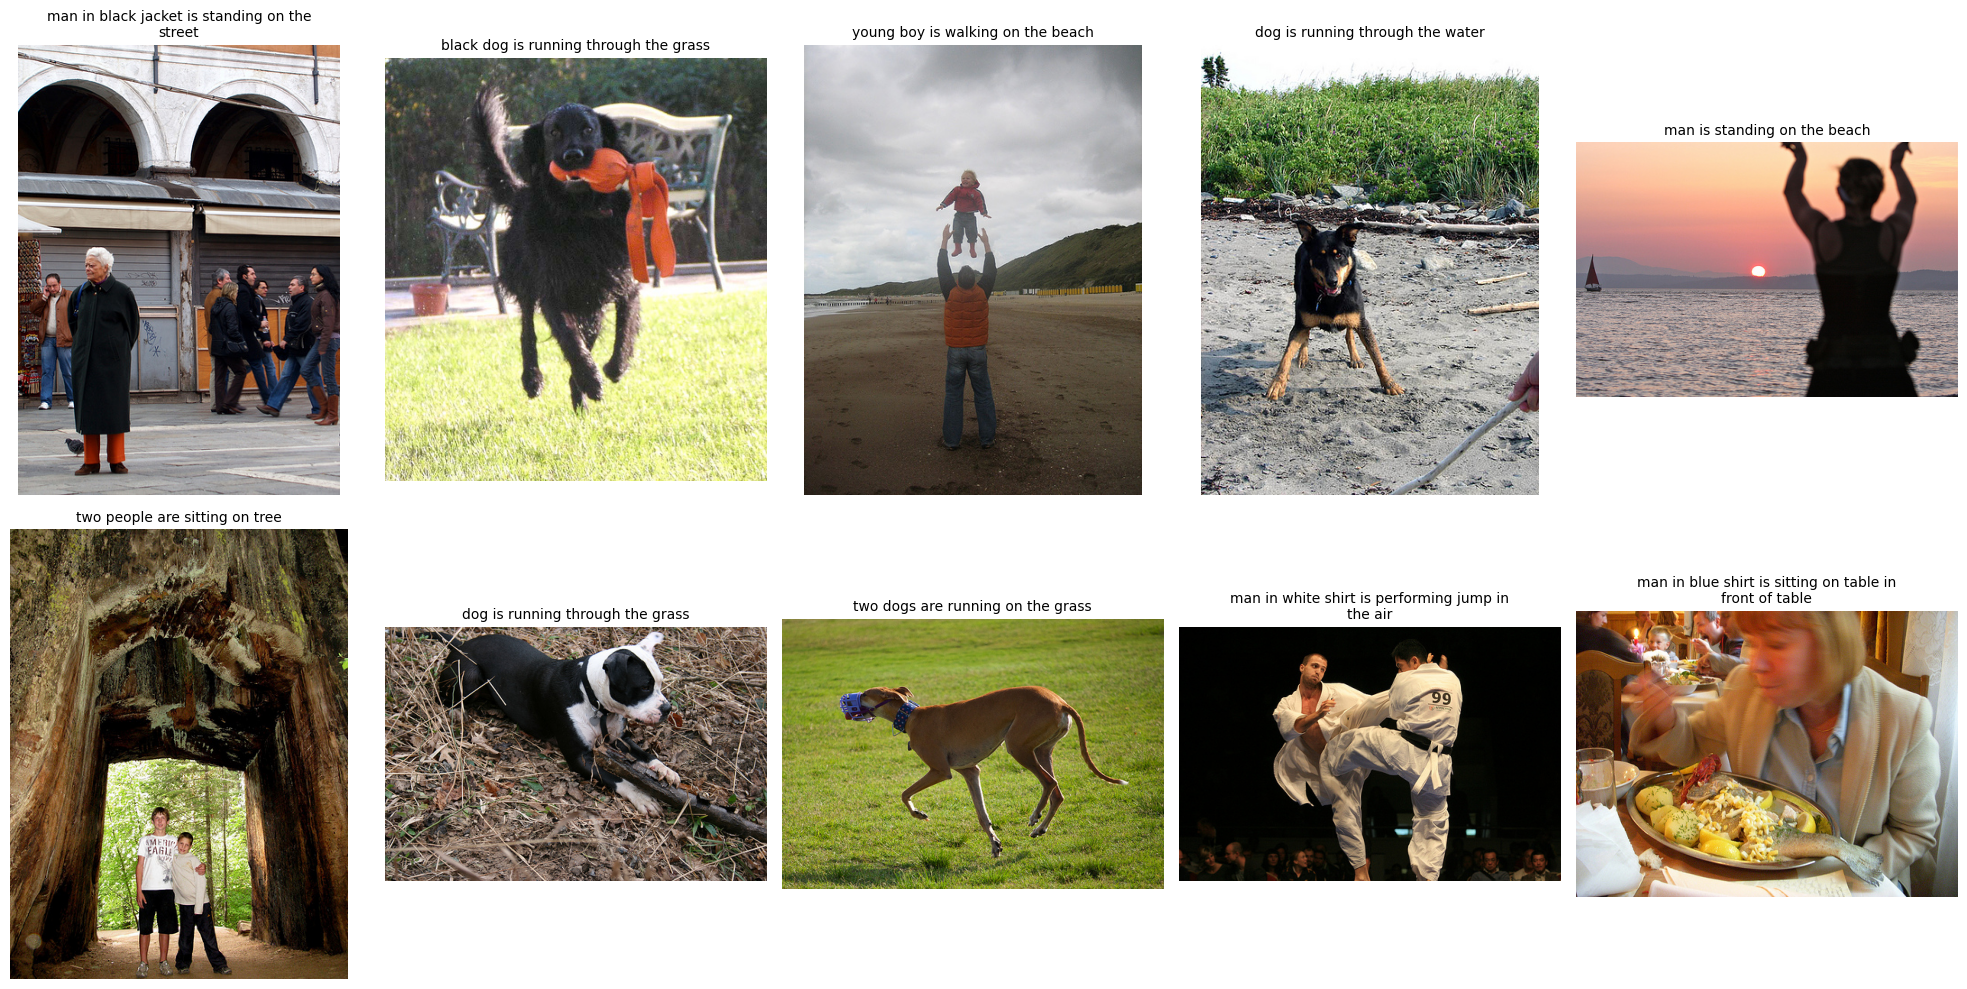

In [213]:
# Randomly select 10 images
selected_images = random.sample(all_images, 10)

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

feature_map = {}

for i, image_file in enumerate(selected_images):
    # Load the image
    image_path = os.path.join(image_dir, image_file)
    img = mpimg.imread(image_path)

    # Extract image features and store in the feature map dictionary
    img_array = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img_array) / 255.0
    feature_map[image_file] = fe.predict(np.expand_dims(img_array, axis=0))
    
    # Generate a caption for the image
    caption = generate_caption(caption_model, image_file, tokenizer, max_length, feature_map)
    wrapped_caption = '\n'.join(wrap(caption, 40))   # Wrap text every 40 characters

    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(wrapped_caption, fontsize=10)  # Set the caption as the title
    ax.axis('off')

plt.tight_layout()
plt.show()

# Reference
1. https://blog.csdn.net/qq_45258667/article/details/124002881
2. https://stackoverflow.com/questions/71812767/how-to-stop-python-from-truncating-print-statements
3. https://colab.research.google.com/drive/1rGMKMeGqimnAzEGplevD1OSuGHmgi8UY?usp=sharing
4. https://github.com/keras-team/keras-io/blob/master/examples/nlp/semantic_similarity_with_bert.py
5. https://www.kaggle.com/code/quadeer15sh/flickr8k-image-captioning-using-cnns-lstms
6. https://github.com/tensorflow/tensorflow/issues/51472
7. https://github.com/Ankuraxz/Image-Caption-Generator/blob/master/Image%20Captioning.ipynb
8. https://github.com/BA-865/BA865FaceRecognition_Group8_B1/blob/main/CNN_Customized_ResNet18_ResNet50.ipynb
9. https://docs.wandb.ai/guides/sweeps/pause-resume-and-cancel-sweeps
10. https://www.kaggle.com/code/shweta2407/vgg16-and-lstm-image-caption-generator
11. https://stackoverflow.com/questions/30791550/limit-number-of-threads-in-numpy
12. https://github.com/PaddlePaddle/Paddle/issues/17615
13. https://github.com/Sajid030/image-caption-generator/blob/master/image-captioner.ipynb
14. https://www.kaggle.com/code/ysthehurricane/image-caption-generator-tutorial
15. https://www.kaggle.com/code/hsankesara/image-captioning
16. https://openaccess.thecvf.com/content_ICCV_2019/papers/Huang_Attention_on_Attention_for_Image_Captioning_ICCV_2019_paper.pdf
17. https://github.com/yuanxiaosc/Image-Captioning
18. https://github.com/IEEE-NITK/Image_Captioning
19. https://paperswithcode.com/sota/image-captioning-on-coco-captions